# Part I: Set Up

- Import Packages

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import os
from statistics import mean
from keras import backend as K
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.core import Flatten
from mosek.fusion import *

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Initialize Variables

In [2]:
seq_len

NameError: name 'seq_len' is not defined

In [2]:
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.5
epochs = 90
os.chdir("/Users/youssefberrada/Dropbox (MIT)/15.961 Independant Study/Data")
#os.chdir("/Users/michelcassard/Dropbox (MIT)/15.960 Independant Study/Data")
file = 'FX-5-merg.xlsx'
# Load spreadsheet
xl = pd.ExcelFile(file)

# Part 2: Data

- Load Data

In [3]:
def get_stock_data(stock_name, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    
    """
    df = xl.parse(stock_name)
    df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'NUMBER_TICKS': 'Volume', 'LAST_PRICE': 'Adj Close'}, inplace=True)
     # Percentage change
    df['Pct'] = df['Adj Close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['Adj Close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
  
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['Adj Close']
    df.drop(labels=['Adj Close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [4]:
df_GBP=get_stock_data("GBP Curncy",  ma=[50, 100, 200])

- Visualize the data

In [5]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

                       Open    High     Low  Volume       Pct      50ma  \
Date                                                                      
2017-09-26 09:45:00  1.3444  1.3433  1.3442    4299 -0.000372  1.343802   
2017-09-26 09:50:00  1.3447  1.3437  1.3437    4947  0.000521  1.343738   
2017-09-26 09:55:00  1.3446  1.3431  1.3444    5552 -0.000818  1.343648   
2017-09-26 10:00:00  1.3438  1.3431  1.3433    7210  0.000074  1.343562   
2017-09-26 10:05:00  1.3443  1.3432  1.3434    5257  0.000447  1.343502   

                        100ma     200ma  Adj Close  
Date                                                
2017-09-26 09:45:00  1.346129  1.346931     1.3437  
2017-09-26 09:50:00  1.346099  1.346920     1.3444  
2017-09-26 09:55:00  1.346056  1.346904     1.3433  
2017-09-26 10:00:00  1.346018  1.346886     1.3434  
2017-09-26 10:05:00  1.345986  1.346872     1.3440  


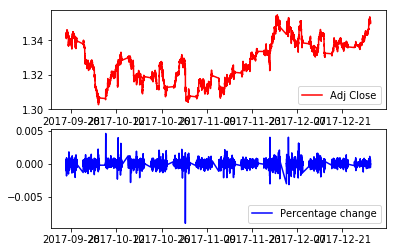

In [6]:
plot_stock(df_GBP)

- Training/Test Set

In [7]:
def load_data(stock,normalize,seq_len,split,ma):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    sequence_length = seq_len + 1 
    result_train = []
    result_test= []
    row = round(split * stock.shape[0]) 
    df_train=stock[0:row].copy()
    print ("Amount of training data = {}".format(df_train.shape[0]))
    df_test=stock[row:len(stock)].copy()
    print ("Amount of testing data = {}".format(df_test.shape[0]))

    
    if normalize:
        #Training
        min_max_scaler = preprocessing.MinMaxScaler()
        df_train['Open'] = min_max_scaler.fit_transform(df_train.Open.values.reshape(-1,1))
        df_train['High'] = min_max_scaler.fit_transform(df_train.High.values.reshape(-1,1))
        df_train['Low'] = min_max_scaler.fit_transform(df_train.Low.values.reshape(-1,1))
        df_train['Volume'] = min_max_scaler.fit_transform(df_train.Volume.values.reshape(-1,1))
        df_train['Adj Close'] = min_max_scaler.fit_transform(df_train['Adj Close'].values.reshape(-1,1))
        df_train['Pct'] = min_max_scaler.fit_transform(df_train['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df_train['{}ma'.format(moving)] = min_max_scaler.fit_transform(df_train['{}ma'.format(moving)].values.reshape(-1,1))  
        #Test
        df_test['Open'] = min_max_scaler.fit_transform(df_test.Open.values.reshape(-1,1))
        df_test['High'] = min_max_scaler.fit_transform(df_test.High.values.reshape(-1,1))
        df_test['Low'] = min_max_scaler.fit_transform(df_test.Low.values.reshape(-1,1))
        df_test['Volume'] = min_max_scaler.fit_transform(df_test.Volume.values.reshape(-1,1))
        df_test['Adj Close'] = min_max_scaler.fit_transform(df_test['Adj Close'].values.reshape(-1,1))
        df_test['Pct'] = min_max_scaler.fit_transform(df_test['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df_test['{}ma'.format(moving)] = min_max_scaler.fit_transform(df_test['{}ma'.format(moving)].values.reshape(-1,1))  
     
    #Training
    data_train = df_train.as_matrix()
    for index in range(len(data_train) - sequence_length): 
        result_train.append(data_train[index: index + sequence_length]) 
    train = np.array(result_train)
    X_train = train[:, :-1].copy() # all data until day m
    y_train = train[:, -1][:,-1].copy() # day m + 1 adjusted close price

    #Test
    data_test = df_test.as_matrix()
    for index in range(len(data_test) - sequence_length): 
        result_test.append(data_test[index: index + sequence_length]) 
    test = np.array(result_train)
    X_test = test[:, :-1].copy()
    y_test = test[:, -1][:,-1].copy()

    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [8]:
X_train, y_train, X_test, y_test = load_data(df_GBP,True,seq_len,split=0.7,ma=[50, 100, 200])

Amount of features = 9
Amount of training data = 13724
Amount of testing data = 5882


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# 3. Model

In [9]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    #model.add(Dense(neurons[0],activation="relu", input_shape=(shape[0], shape[1])))
    
    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [10]:
def build_model_CNN(shape, neurons, dropout, decay):
    model = Sequential()
    model.add(Convolution1D(input_shape = (shape[0], shape[1]), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=2))

    model.add(Convolution1D(input_shape = (shape[0], shape[1]), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=2))

    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(250))
    model.add(Dropout(0.25))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('linear'))
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [11]:
model = build_model_CNN(shape, neurons, dropout, decay)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 21, 64)            1216      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 64)             8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
___________________________________________________________

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


# 4. Results

- Model Fit

In [56]:
model.fit(X_train,y_train,batch_size=512,epochs=epochs,validation_split=0.3,verbose=1)

Train on 9782 samples, validate on 4193 samples
Epoch 1/90
9782/9782 [==============================] - 2s 157us/step - loss: 0.0300 - acc: 1.0223e-04 - val_loss: 0.0027 - val_acc: 2.3849e-04
Epoch 2/90
9782/9782 [==============================] - 0s 45us/step - loss: 0.0062 - acc: 1.0223e-04 - val_loss: 8.3929e-04 - val_acc: 2.3849e-04
Epoch 3/90
9782/9782 [==============================] - 0s 46us/step - loss: 0.0040 - acc: 1.0223e-04 - val_loss: 0.0019 - val_acc: 2.3849e-04
Epoch 4/90
9782/9782 [==============================] - 1s 53us/step - loss: 0.0031 - acc: 1.0223e-04 - val_loss: 0.0017 - val_acc: 2.3849e-04
Epoch 5/90
9782/9782 [==============================] - 0s 44us/step - loss: 0.0025 - acc: 1.0223e-04 - val_loss: 0.0021 - val_acc: 2.3849e-04
Epoch 6/90
9782/9782 [==============================] - 1s 53us/step - loss: 0.0023 - acc: 1.0223e-04 - val_loss: 0.0019 - val_acc: 2.3849e-04
Epoch 7/90
9782/9782 [==============================] - 1s 57us/step - loss: 0.0019 - acc

- Model Score

In [12]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [58]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00037 MSE (0.02 RMSE)
Test Score: 0.00037 MSE (0.02 RMSE)


(0.0003710565636182714, 0.0003710565636182714)

In [13]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    print(mean(percentage_diff))
    return p

In [232]:
p = percentage_difference(model, X_test, y_test)

523.7988228254899


In [14]:
def plot_result_norm(stock_name, normalized_value_p, normalized_value_y_test):
    newp=normalized_value_p
    newy_test=normalized_value_y_test
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('5 Min ahead Forecast')
    plt2.ylabel('Price')
    plt2.show()

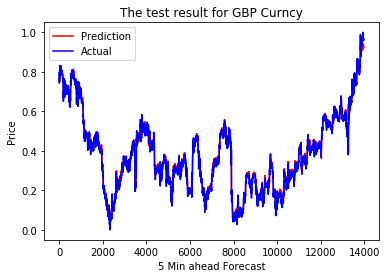

In [62]:
plot_result_norm("GBP Curncy", p, y_test)

In [15]:
def denormalize(stock_name, normalized_value,split=0.7,predict=True):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = xl.parse(stock_name)
    df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'NUMBER_TICKS': 'Volume', 'LAST_PRICE': 'Adj Close'}, inplace=True)


    df.dropna(inplace=True)
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    row = round(split * df.shape[0]) 
    if predict:
        df_p=df[0:row].copy()
    else:
        df_p=df[row:len(df)].copy()
    
    #return df.shape, p.shape
    mean_df=np.mean(df_p)
    std_df=np.std(df_p)
    new=normalized_value*mean_df+std_df
      
    return new

In [16]:
def portfolio(currency_list,file = 'FX-5.xlsx',seq_len = 22,shape = [seq_len, 9, 1],neurons = [256, 256, 32, 1],dropout = 0.3,decay = 0.5,
              epochs = 90,ma=[50, 100, 200],split=0.7):
    i=0
    mini=99999999
    for currency in currency_list:
        df=get_stock_data(currency,  ma)
        X_train, y_train, X_test, y_test = load_data(df,True,seq_len,split,ma)
        model = build_model_CNN(shape, neurons, dropout, decay)
        model.fit(X_train,y_train,batch_size=512,epochs=epochs,validation_split=0.3,verbose=1)
        p = percentage_difference(model, X_test, y_test)
        newp = denormalize(currency, p,predict=True)
        if mini>p.size:
            mini=p.size
        if i==0:
            predict=p.copy()
        else:
            predict=np.hstack((predict[0:mini],p[0:mini]))
        i+=1
    return predict


In [17]:
#currency_list=[ 'GBP Curncy',
# 'JPY Curncy',
# 'EUR Curncy',
# 'CAD Curncy',
# 'NZD Curncy',
# 'SEK Curncy',
# 'AUD Curncy',
# 'CHF Curncy',
# 'NOK Curncy',
# 'ZAR Curncy']
currency_list=[ 'GBP Curncy',
 'JPY Curncy',
 'EUR Curncy']
#currency_list=['JPY Curncy']
predictcur=portfolio(currency_list,file = 'FX-5.xlsx',seq_len = 22,shape = [seq_len, 9, 1],neurons = [256, 256, 32, 1],dropout = 0.3,decay = 0.5,
              epochs = 10,ma=[50, 100, 200],split=0.7)

Amount of features = 9
Amount of training data = 13724
Amount of testing data = 5882


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Ke

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 21, 64)            1216      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 9, 64)             8256      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               64250     
__________

Train on 9590 samples, validate on 4111 samples
Epoch 1/10
9590/9590 [==============================] - 1s 97us/step - loss: 0.0267 - acc: 1.0428e-04 - val_loss: 0.0070 - val_acc: 2.4325e-04
Epoch 2/10
9590/9590 [==============================] - 0s 44us/step - loss: 0.0072 - acc: 1.0428e-04 - val_loss: 0.0017 - val_acc: 2.4325e-04
Epoch 3/10
9590/9590 [==============================] - 0s 47us/step - loss: 0.0044 - acc: 1.0428e-04 - val_loss: 0.0044 - val_acc: 2.4325e-04
Epoch 4/10
9590/9590 [==============================] - 1s 55us/step - loss: 0.0035 - acc: 1.0428e-04 - val_loss: 0.0033 - val_acc: 2.4325e-04
Epoch 5/10
9590/9590 [==============================] - 1s 55us/step - loss: 0.0029 - acc: 1.0428e-04 - val_loss: 0.0020 - val_acc: 2.4325e-04
Epoch 6/10
9590/9590 [==============================] - 1s 53us/step - loss: 0.0024 - acc: 1.0428e-04 - val_loss: 0.0015 - val_acc: 2.4325e-04
Epoch 7/10
9590/9590 [==============================] - 1s 57us/step - loss: 0.0022 - acc: 1.0

In [236]:
predictcur.shape

(13701, 3)

In [18]:
"""
    Description:
        Extends the basic Markowitz model with a market cost term.

    Input:
        n: Number of assets
        mu: An n dimensional vector of expected returns
        GT: A matrix with n columns so (GT')*GT  = covariance matrix
        x0: Initial holdings 
        w: Initial cash holding
        gamma: Maximum risk (=std. dev) accepted
        f: If asset j is traded then a fixed cost f_j must be paid
        g: If asset j is traded then a cost g_j must be paid for each unit traded

    Output:
       Optimal expected return and the optimal portfolio     

"""
def MarkowitzWithTransactionsCost(n,mu,GT,x0,w,gamma,f,g):
    # Upper bound on the traded amount
    w0 = w+sum(x0)
    u = n*[w0]

    with Model("Markowitz portfolio with transaction costs") as M:
        #M.setLogHandler(sys.stdout)

        # Defines the variables. No shortselling is allowed.
        x = M.variable("x", n, Domain.greaterThan(0.0))

        # Additional "helper" variables 
        z = M.variable("z", n, Domain.unbounded())   
        # Binary variables
        y = M.variable("y", n, Domain.binary())

        #  Maximize expected return
        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(mu,x))

        # Invest amount + transactions costs = initial wealth
        M.constraint('budget', Expr.add([ Expr.sum(x), Expr.dot(f,y),Expr.dot(g,z)] ), Domain.equalsTo(w0))

        # Imposes a bound on the risk
        M.constraint('risk', Expr.vstack( gamma,Expr.mul(GT,x)), Domain.inQCone())

        # z >= |x-x0| 
        M.constraint('buy', Expr.sub(z,Expr.sub(x,x0)),Domain.greaterThan(0.0))
        M.constraint('sell', Expr.sub(z,Expr.sub(x0,x)),Domain.greaterThan(0.0))
        # Alternatively, formulate the two constraints as
        #M.constraint('trade', Expr.hstack(z,Expr.sub(x,x0)), Domain.inQcone())

        # Constraints for turning y off and on. z-diag(u)*y<=0 i.e. z_j <= u_j*y_j
        M.constraint('y_on_off', Expr.sub(z,Expr.mulElm(u,y)), Domain.lessThan(0.0))

        # Integer optimization problems can be very hard to solve so limiting the 
        # maximum amount of time is a valuable safe guard
        M.setSolverParam('mioMaxTime', 180.0) 
        M.solve()

        #print("\n-----------------------------------------------------------------------------------");
        #print('Markowitz portfolio optimization with transactions cost')
        #print("-----------------------------------------------------------------------------------\n");
        #print('Expected return: %.4e Std. deviation: %.4e Transactions cost: %.4e' % \
              #(np.dot(mu,x.level()),gamma,np.dot(f,y.level())+np.dot(g,z.level())))

        return (np.dot(mu,x.level()), x.level())

In [69]:
def rebalance_y(n,previous_prices,x0,w,mu,gamma=1):
    GT=np.cov(previous_prices)
    f = n*[0]
    g = n*[0.0005]
    _,weights=MarkowitzWithTransactionsCost(n,mu,GT,x0,w,gamma,f,g)
    return weights

In [20]:
close = pd.ExcelFile('close.xlsx')
dq=np.array(close.parse(0))

In [21]:
dq=dq[:,0:3]

In [34]:
dq[1,:]

array([  1.3465, 111.72  ,   1.1849])

In [213]:
random.seed(1)
prices = np.array([random.gauss(100, 1) for _ in range(11*300)])
prices = np.reshape(prices,(11,300))
predictions = np.array([random.gauss(100, 1) for _ in range(11*100)])
predictions = np.reshape(predictions,(11,100))
initial_weights = np.repeat(1/11,11)

In [215]:
# Backtesting using rebalancing function for weights
random.seed(1)
prices = np.array([random.gauss(100, 1) for _ in range(11*300)])
prices = np.reshape(prices,(11,300))
predictions = np.array([random.gauss(100, 1) for _ in range(11*100)])
predictions = np.reshape(predictions,(11,100))
initial_weights = np.repeat(1/11,11)

def log_diff(data):
    return np.diff(np.log(data))

t_prices = len(prices[1,:])
t_predictions = len(predictions[1,:])
length_past = t_prices - t_predictions
prediction_return = []
for k in range(t_predictions):
    prediction_return.append(np.log(predictions[:,k]/prices[:,length_past+k]))


def backtest(prices, predictions, initial_weights):
    t_prices = len(prices[1,:])
    t_predictions = len(predictions[1,:])
    length_past = t_prices - t_predictions
    returns = np.apply_along_axis(log_diff, 1, prices)
    prediction_return = []
    for k in range(t_predictions):
        prediction_return.append(np.log(predictions[:,k]/prices[:,length_past+k]))
    prediction_return = np.asarray(prediction_return).T    
    weights = initial_weights
    portfolio_return = []
    for i in range(0,t_predictions-1):
        predicted_price = predictions[:,i]
        previous_price = prices[:,length_past+i]
        previous_prices = prices[:,0:length_past+i]
        prev_weight = weights
        new_weight = rebalance_y(3,previous_prices,mu=predicted_price,x0=prev_weight,w=1,gamma=0.5)
        period_return = np.log((new_weight*prices[:,length_past+i+1])/(prev_weight*prices[:,length_past+i]))
        portfolio_return.append(np.sum(period_return))
        prev_weight = new_weight
    return portfolio_return

In [75]:
def log_diff(data):
    return np.diff(np.log(data))
def backtest(prices, predictions, initial_weights):
    t_prices = len(prices[1,:])
    t_predictions = len(predictions[:,1])
    length_past = t_prices - t_predictions
    returns = np.apply_along_axis(log_diff, 1, prices)
    prediction_return = []
    for k in range(t_predictions):
        prediction_return.append(np.log(predictions[k]/prices[:,length_past+k]))
    weights = initial_weights
    portfolio_return = []
    prev_weight = weights
    for i in range(0,t_predictions-1):
        print(i)
        predicted_return = prediction_return[i]
        previous_return = returns[:,length_past+i]
        previous_returns = returns[:,0:length_past+i]
        print(i)
        new_weight = rebalance_y(3,previous_returns,mu=predicted_return.tolist(),x0=prev_weight,w=1,gamma=0.5)
        period_return = np.log((new_weight*prices[:,length_past+i+1])/(prev_weight*prices[:,length_past+i]))
        portfolio_return.append(np.sum(period_return))
        prev_weight = new_weight
    return portfolio_return

In [36]:
prices=dq.T
predictions=predictcur
initial_weights=np.repeat(1/3,3)

In [37]:
    t_prices = len(prices[1,:])
    t_predictions = len(predictions[:,1])
    length_past = t_prices - t_predictions

In [40]:
returns = np.apply_along_axis(log_diff, 1, prices)

In [49]:
prediction_return = []
for k in range(t_predictions):
    prediction_return.append(np.log(predictions[k]/prices[:,length_past+k]))

In [63]:
        predicted_return = prediction_return[0]
        previous_return = returns[:,length_past+5]
        previous_returns = returns[:,0:length_past+0]

In [68]:
predicted_return.tolist()

[-0.559405707316643, -5.828390908582265, -0.8645518301785]

In [65]:
previous_return

array([ 7.61643627e-05,  0.00000000e+00, -1.70068028e-04])

In [66]:
np.cov(previous_returns)

array([[ 9.25340793e-08, -2.56514995e-08,  3.52774574e-08],
       [-2.56514995e-08,  6.88287041e-08, -3.41686514e-08],
       [ 3.52774574e-08, -3.41686514e-08,  5.63641242e-08]])

In [70]:
rebalance_y(3,previous_returns,mu=predicted_return.tolist(),x0=[0.0,0.0,0.0],w=1,gamma=1.)

array([ 9.98500078e-01, -1.90801196e-08,  6.01256735e-08])

In [76]:
backtest(dq.T, predictcur, np.repeat(1/3,3))

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152
152
153
153
154
154
155
155
156
156
157
157
158
158
159
159
160
160
161
161
162
162
163
163
164
164
165
165
166


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


209
209
210
210
211
211
212
212
213
213
214
214
215
215
216
216
217
217
218
218
219
219
220
220
221
221
222
222
223
223
224
224
225
225
226
226
227
227
228
228
229
229
230
230
231
231
232
232
233
233
234
234
235
235
236
236
237
237
238
238
239
239
240
240
241
241
242
242
243
243
244
244
245
245
246
246
247
247
248
248
249
249
250
250
251
251
252
252
253
253
254
254
255
255
256
256
257
257
258
258
259
259
260
260
261
261
262
262
263
263
264
264
265
265
266
266
267
267
268
268
269
269
270
270
271
271
272
272
273
273
274
274
275
275
276
276
277
277
278
278
279
279
280
280
281
281
282
282
283
283
284
284
285
285
286
286
287
287
288
288
289
289
290
290
291
291
292
292
293
293
294
294
295
295
296
296
297
297
298
298
299
299
300
300
301
301
302
302
303
303
304
304
305
305
306
306
307
307
308
308
309
309
310
310
311
311
312
312
313
313
314
314
315
315
316
316
317
317
318
318
319
319
320
320
321
321
322
322
323
323
324
324
325
325
326
326
327
327
328
328
329
329
330
330
331
331
332
332
333
333


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


1061
1061
1062
1062
1063
1063
1064
1064
1065
1065
1066
1066
1067
1067
1068
1068
1069
1069
1070
1070
1071
1071
1072
1072
1073
1073
1074
1074
1075
1075
1076
1076
1077
1077
1078
1078
1079
1079
1080
1080
1081
1081
1082
1082
1083
1083
1084
1084
1085
1085
1086
1086
1087
1087
1088
1088
1089
1089
1090
1090
1091
1091
1092
1092
1093
1093
1094
1094
1095
1095
1096
1096
1097
1097
1098
1098
1099
1099
1100
1100
1101
1101
1102
1102
1103
1103
1104
1104
1105
1105
1106
1106
1107
1107
1108
1108
1109
1109
1110
1110
1111
1111
1112
1112
1113
1113
1114
1114
1115
1115
1116
1116
1117
1117
1118
1118
1119
1119
1120
1120
1121
1121
1122
1122
1123
1123
1124
1124
1125
1125
1126
1126
1127
1127
1128
1128
1129
1129
1130
1130
1131
1131
1132
1132
1133
1133
1134
1134
1135
1135
1136
1136
1137
1137
1138
1138
1139
1139
1140
1140
1141
1141
1142
1142
1143
1143
1144
1144
1145
1145
1146
1146
1147
1147
1148
1148
1149
1149
1150
1150
1151
1151
1152
1152
1153
1153
1154
1154
1155
1155
1156
1156
1157
1157
1158
1158
1159
1159
1160
1160


1881
1881
1882
1882
1883
1883
1884
1884
1885
1885
1886
1886
1887
1887
1888
1888
1889
1889
1890
1890
1891
1891
1892
1892
1893
1893
1894
1894
1895
1895
1896
1896
1897
1897
1898
1898
1899
1899
1900
1900
1901
1901
1902
1902
1903
1903
1904
1904
1905
1905
1906
1906
1907
1907
1908
1908
1909
1909
1910
1910
1911
1911
1912
1912
1913
1913
1914
1914
1915
1915
1916
1916
1917
1917
1918
1918
1919
1919
1920
1920
1921
1921
1922
1922
1923
1923
1924
1924
1925
1925
1926
1926
1927
1927
1928
1928
1929
1929
1930
1930
1931
1931
1932
1932
1933
1933
1934
1934
1935
1935
1936
1936
1937
1937
1938
1938
1939
1939
1940
1940
1941
1941
1942
1942
1943
1943
1944
1944
1945
1945
1946
1946
1947
1947
1948
1948
1949
1949
1950
1950
1951
1951
1952
1952
1953
1953
1954
1954
1955
1955
1956
1956
1957
1957
1958
1958
1959
1959
1960
1960
1961
1961
1962
1962
1963
1963
1964
1964
1965
1965
1966
1966
1967
1967
1968
1968
1969
1969
1970
1970
1971
1971
1972
1972
1973
1973
1974
1974
1975
1975
1976
1976
1977
1977
1978
1978
1979
1979
1980
1980


/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


2330
2330
2331
2331
2332
2332
2333
2333
2334
2334
2335
2335
2336
2336
2337
2337
2338
2338
2339
2339
2340
2340
2341
2341
2342
2342
2343
2343
2344
2344
2345
2345
2346
2346
2347
2347
2348
2348
2349
2349
2350
2350
2351
2351
2352
2352
2353
2353
2354
2354
2355
2355
2356
2356
2357
2357
2358
2358
2359
2359
2360
2360
2361
2361
2362
2362
2363
2363
2364
2364
2365
2365
2366
2366
2367
2367
2368
2368
2369
2369
2370
2370
2371
2371
2372
2372
2373
2373
2374
2374
2375
2375
2376
2376
2377
2377
2378
2378
2379
2379
2380
2380
2381
2381
2382
2382
2383
2383
2384
2384
2385
2385
2386
2386
2387
2387
2388
2388
2389
2389
2390
2390
2391
2391
2392
2392
2393
2393
2394
2394
2395
2395
2396
2396
2397
2397
2398
2398
2399
2399
2400
2400
2401
2401
2402
2402
2403
2403
2404
2404
2405
2405
2406
2406
2407
2407
2408
2408
2409
2409
2410
2410
2411
2411
2412
2412
2413
2413
2414
2414
2415
2415
2416
2416
2417
2417
2418
2418
2419
2419
2420
2420
2421
2421
2422
2422
2423
2423
2424
2424
2425
2425
2426
2426
2427
2427
2428
2428
2429
2429


3154
3154
3155
3155
3156
3156
3157
3157
3158
3158
3159
3159
3160
3160
3161
3161
3162
3162
3163
3163
3164
3164
3165
3165
3166
3166
3167
3167
3168
3168
3169
3169
3170
3170
3171
3171
3172
3172
3173
3173
3174
3174
3175
3175
3176
3176
3177
3177
3178
3178
3179
3179
3180
3180
3181
3181
3182
3182
3183
3183
3184
3184
3185
3185
3186
3186
3187
3187
3188
3188
3189
3189
3190
3190
3191
3191
3192
3192
3193
3193
3194
3194
3195
3195
3196
3196
3197
3197
3198
3198
3199
3199
3200
3200
3201
3201
3202
3202
3203
3203
3204
3204
3205
3205
3206
3206
3207
3207
3208
3208
3209
3209
3210
3210
3211
3211
3212
3212
3213
3213
3214
3214
3215
3215
3216
3216
3217
3217
3218
3218
3219
3219
3220
3220
3221
3221
3222
3222
3223
3223
3224
3224
3225
3225
3226
3226
3227
3227
3228
3228
3229
3229
3230
3230
3231
3231
3232
3232
3233
3233
3234
3234
3235
3235
3236
3236
3237
3237
3238
3238
3239
3239
3240
3240
3241
3241
3242
3242
3243
3243
3244
3244
3245
3245
3246
3246
3247
3247
3248
3248
3249
3249
3250
3250
3251
3251
3252
3252
3253
3253


3992
3992
3993
3993
3994
3994
3995
3995
3996
3996
3997
3997
3998
3998
3999
3999
4000
4000
4001
4001
4002
4002
4003
4003
4004
4004
4005
4005
4006
4006
4007
4007
4008
4008
4009
4009
4010
4010
4011
4011
4012
4012
4013
4013
4014
4014
4015
4015
4016
4016
4017
4017
4018
4018
4019
4019
4020
4020
4021
4021
4022
4022
4023
4023
4024
4024
4025
4025
4026
4026
4027
4027
4028
4028
4029
4029
4030
4030
4031
4031
4032
4032
4033
4033
4034
4034
4035
4035
4036
4036
4037
4037
4038
4038
4039
4039
4040
4040
4041
4041
4042
4042
4043
4043
4044
4044
4045
4045
4046
4046
4047
4047
4048
4048
4049
4049
4050
4050
4051
4051
4052
4052
4053
4053
4054
4054
4055
4055
4056
4056
4057
4057
4058
4058
4059
4059
4060
4060
4061
4061
4062
4062
4063
4063
4064
4064
4065
4065
4066
4066
4067
4067
4068
4068
4069
4069
4070
4070
4071
4071
4072
4072
4073
4073
4074
4074
4075
4075
4076
4076
4077
4077
4078
4078
4079
4079
4080
4080
4081
4081
4082
4082
4083
4083
4084
4084
4085
4085
4086
4086
4087
4087
4088
4088
4089
4089
4090
4090
4091
4091


4829
4829
4830
4830
4831
4831
4832
4832
4833
4833
4834
4834
4835
4835
4836
4836
4837
4837
4838
4838
4839
4839
4840
4840
4841
4841
4842
4842
4843
4843
4844
4844
4845
4845
4846
4846
4847
4847
4848
4848
4849
4849
4850
4850
4851
4851
4852
4852
4853
4853
4854
4854
4855
4855
4856
4856
4857
4857
4858
4858
4859
4859
4860
4860
4861
4861
4862
4862
4863
4863
4864
4864
4865
4865
4866
4866
4867
4867
4868
4868
4869
4869
4870
4870
4871
4871
4872
4872
4873
4873
4874
4874
4875
4875
4876
4876
4877
4877
4878
4878
4879
4879
4880
4880
4881
4881
4882
4882
4883
4883
4884
4884
4885
4885
4886
4886
4887
4887
4888
4888
4889
4889
4890
4890
4891
4891
4892
4892
4893
4893
4894
4894
4895
4895
4896
4896
4897
4897
4898
4898
4899
4899
4900
4900
4901
4901
4902
4902
4903
4903
4904
4904
4905
4905
4906
4906
4907
4907
4908
4908
4909
4909
4910
4910
4911
4911
4912
4912
4913
4913
4914
4914
4915
4915
4916
4916
4917
4917
4918
4918
4919
4919
4920
4920
4921
4921
4922
4922
4923
4923
4924
4924
4925
4925
4926
4926
4927
4927
4928
4928


5666
5666
5667
5667
5668
5668
5669
5669
5670
5670
5671
5671
5672
5672
5673
5673
5674
5674
5675
5675
5676
5676
5677
5677
5678
5678
5679
5679
5680
5680
5681
5681
5682
5682
5683
5683
5684
5684
5685
5685
5686
5686
5687
5687
5688
5688
5689
5689
5690
5690
5691
5691
5692
5692
5693
5693
5694
5694
5695
5695
5696
5696
5697
5697
5698
5698
5699
5699
5700
5700
5701
5701
5702
5702
5703
5703
5704
5704
5705
5705
5706
5706
5707
5707
5708
5708
5709
5709
5710
5710
5711
5711
5712
5712
5713
5713
5714
5714
5715
5715
5716
5716
5717
5717
5718
5718
5719
5719
5720
5720
5721
5721
5722
5722
5723
5723
5724
5724
5725
5725
5726
5726
5727
5727
5728
5728
5729
5729
5730
5730
5731
5731
5732
5732
5733
5733
5734
5734
5735
5735
5736
5736
5737
5737
5738
5738
5739
5739
5740
5740
5741
5741
5742
5742
5743
5743
5744
5744
5745
5745
5746
5746
5747
5747
5748
5748
5749
5749
5750
5750
5751
5751
5752
5752
5753
5753
5754
5754
5755
5755
5756
5756
5757
5757
5758
5758
5759
5759
5760
5760
5761
5761
5762
5762
5763
5763
5764
5764
5765
5765


6494
6494
6495
6495
6496
6496
6497
6497
6498
6498
6499
6499
6500
6500
6501
6501
6502
6502
6503
6503
6504
6504
6505
6505
6506
6506
6507
6507
6508
6508
6509
6509
6510
6510
6511
6511
6512
6512
6513
6513
6514
6514
6515
6515
6516
6516
6517
6517
6518
6518
6519
6519
6520
6520
6521
6521
6522
6522
6523
6523
6524
6524
6525
6525
6526
6526
6527
6527
6528
6528
6529
6529
6530
6530
6531
6531
6532
6532
6533
6533
6534
6534
6535
6535
6536
6536
6537
6537
6538
6538
6539
6539
6540
6540
6541
6541
6542
6542
6543
6543
6544
6544
6545
6545
6546
6546
6547
6547
6548
6548
6549
6549
6550
6550
6551
6551
6552
6552
6553
6553
6554
6554
6555
6555
6556
6556
6557
6557
6558
6558
6559
6559
6560
6560
6561
6561
6562
6562
6563
6563
6564
6564
6565
6565
6566
6566
6567
6567
6568
6568
6569
6569
6570
6570
6571
6571
6572
6572
6573
6573
6574
6574
6575
6575
6576
6576
6577
6577
6578
6578
6579
6579
6580
6580
6581
6581
6582
6582
6583
6583
6584
6584
6585
6585
6586
6586
6587
6587
6588
6588
6589
6589
6590
6590
6591
6591
6592
6592
6593
6593


7322
7322
7323
7323
7324
7324
7325
7325
7326
7326
7327
7327
7328
7328
7329
7329
7330
7330
7331
7331
7332
7332
7333
7333
7334
7334
7335
7335
7336
7336
7337
7337
7338
7338
7339
7339
7340
7340
7341
7341
7342
7342
7343
7343
7344
7344
7345
7345
7346
7346
7347
7347
7348
7348
7349
7349
7350
7350
7351
7351
7352
7352
7353
7353
7354
7354
7355
7355
7356
7356
7357
7357
7358
7358
7359
7359
7360
7360
7361
7361
7362
7362
7363
7363
7364
7364
7365
7365
7366
7366
7367
7367
7368
7368
7369
7369
7370
7370
7371
7371
7372
7372
7373
7373
7374
7374
7375
7375
7376
7376
7377
7377
7378
7378
7379
7379
7380
7380
7381
7381
7382
7382
7383
7383
7384
7384
7385
7385
7386
7386
7387
7387
7388
7388
7389
7389
7390
7390
7391
7391
7392
7392
7393
7393
7394
7394
7395
7395
7396
7396
7397
7397
7398
7398
7399
7399
7400
7400
7401
7401
7402
7402
7403
7403
7404
7404
7405
7405
7406
7406
7407
7407
7408
7408
7409
7409
7410
7410
7411
7411
7412
7412
7413
7413
7414
7414
7415
7415
7416
7416
7417
7417
7418
7418
7419
7419
7420
7420
7421
7421


8161
8161
8162
8162
8163
8163
8164
8164
8165
8165
8166
8166
8167
8167
8168
8168
8169
8169
8170
8170
8171
8171
8172
8172
8173
8173
8174
8174
8175
8175
8176
8176
8177
8177
8178
8178
8179
8179
8180
8180
8181
8181
8182
8182
8183
8183
8184
8184
8185
8185
8186
8186
8187
8187
8188
8188
8189
8189
8190
8190
8191
8191
8192
8192
8193
8193
8194
8194
8195
8195
8196
8196
8197
8197
8198
8198
8199
8199
8200
8200
8201
8201
8202
8202
8203
8203
8204
8204
8205
8205
8206
8206
8207
8207
8208
8208
8209
8209
8210
8210
8211
8211
8212
8212
8213
8213
8214
8214
8215
8215
8216
8216
8217
8217
8218
8218
8219
8219
8220
8220
8221
8221
8222
8222
8223
8223
8224
8224
8225
8225
8226
8226
8227
8227
8228
8228
8229
8229
8230
8230
8231
8231
8232
8232
8233
8233
8234
8234
8235
8235
8236
8236
8237
8237
8238
8238
8239
8239
8240
8240
8241
8241
8242
8242
8243
8243
8244
8244
8245
8245
8246
8246
8247
8247
8248
8248
8249
8249
8250
8250
8251
8251
8252
8252
8253
8253
8254
8254
8255
8255
8256
8256
8257
8257
8258
8258
8259
8259
8260
8260


8986
8986
8987
8987
8988
8988
8989
8989
8990
8990
8991
8991
8992
8992
8993
8993
8994
8994
8995
8995
8996
8996
8997
8997
8998
8998
8999
8999
9000
9000
9001
9001
9002
9002
9003
9003
9004
9004
9005
9005
9006
9006
9007
9007
9008
9008
9009
9009
9010
9010
9011
9011
9012
9012
9013
9013
9014
9014
9015
9015
9016
9016
9017
9017
9018
9018
9019
9019
9020
9020
9021
9021
9022
9022
9023
9023
9024
9024
9025
9025
9026
9026
9027
9027
9028
9028
9029
9029
9030
9030
9031
9031
9032
9032
9033
9033
9034
9034
9035
9035
9036
9036
9037
9037
9038
9038
9039
9039
9040
9040
9041
9041
9042
9042
9043
9043
9044
9044
9045
9045
9046
9046
9047
9047
9048
9048
9049
9049
9050
9050
9051
9051
9052
9052
9053
9053
9054
9054
9055
9055
9056
9056
9057
9057
9058
9058
9059
9059
9060
9060
9061
9061
9062
9062
9063
9063
9064
9064
9065
9065
9066
9066
9067
9067
9068
9068
9069
9069
9070
9070
9071
9071
9072
9072
9073
9073
9074
9074
9075
9075
9076
9076
9077
9077
9078
9078
9079
9079
9080
9080
9081
9081
9082
9082
9083
9083
9084
9084
9085
9085


9807
9807
9808
9808
9809
9809
9810
9810
9811
9811
9812
9812
9813
9813
9814
9814
9815
9815
9816
9816
9817
9817
9818
9818
9819
9819
9820
9820
9821
9821
9822
9822
9823
9823
9824
9824
9825
9825
9826
9826
9827
9827
9828
9828
9829
9829
9830
9830
9831
9831
9832
9832
9833
9833
9834
9834
9835
9835
9836
9836
9837
9837
9838
9838
9839
9839
9840
9840
9841
9841
9842
9842
9843
9843
9844
9844
9845
9845
9846
9846
9847
9847
9848
9848
9849
9849
9850
9850
9851
9851
9852
9852
9853
9853
9854
9854
9855
9855
9856
9856
9857
9857
9858
9858
9859
9859
9860
9860
9861
9861
9862
9862
9863
9863
9864
9864
9865
9865
9866
9866
9867
9867
9868
9868
9869
9869
9870
9870
9871
9871
9872
9872
9873
9873
9874
9874
9875
9875
9876
9876
9877
9877
9878
9878
9879
9879
9880
9880
9881
9881
9882
9882
9883
9883
9884
9884
9885
9885
9886
9886
9887
9887
9888
9888
9889
9889
9890
9890
9891
9891
9892
9892
9893
9893
9894
9894
9895
9895
9896
9896
9897
9897
9898
9898
9899
9899
9900
9900
9901
9901
9902
9902
9903
9903
9904
9904
9905
9905
9906
9906


10526
10526
10527
10527
10528
10528
10529
10529
10530
10530
10531
10531
10532
10532
10533
10533
10534
10534
10535
10535
10536
10536
10537
10537
10538
10538
10539
10539
10540
10540
10541
10541
10542
10542
10543
10543
10544
10544
10545
10545
10546
10546
10547
10547
10548
10548
10549
10549
10550
10550
10551
10551
10552
10552
10553
10553
10554
10554
10555
10555
10556
10556
10557
10557
10558
10558
10559
10559
10560
10560
10561
10561
10562
10562
10563
10563
10564
10564
10565
10565
10566
10566
10567
10567
10568
10568
10569
10569
10570
10570
10571
10571
10572
10572
10573
10573
10574
10574
10575
10575
10576
10576
10577
10577
10578
10578
10579
10579
10580
10580
10581
10581
10582
10582
10583
10583
10584
10584
10585
10585
10586
10586
10587
10587
10588
10588
10589
10589
10590
10590
10591
10591
10592
10592
10593
10593
10594
10594
10595
10595
10596
10596
10597
10597
10598
10598
10599
10599
10600
10600
10601
10601
10602
10602
10603
10603
10604
10604
10605
10605
10606
10606
10607
10607
10608
10608
1060

11219
11219
11220
11220
11221
11221
11222
11222
11223
11223
11224
11224
11225
11225
11226
11226
11227
11227
11228
11228
11229
11229
11230
11230
11231
11231
11232
11232
11233
11233
11234
11234
11235
11235
11236
11236
11237
11237
11238
11238
11239
11239
11240
11240
11241
11241
11242
11242
11243
11243
11244
11244
11245
11245
11246
11246
11247
11247
11248
11248
11249
11249
11250
11250
11251
11251
11252
11252
11253
11253
11254
11254
11255
11255
11256
11256
11257
11257
11258
11258
11259
11259
11260
11260
11261
11261
11262
11262
11263
11263
11264
11264
11265
11265
11266
11266
11267
11267
11268
11268
11269
11269
11270
11270
11271
11271
11272
11272
11273
11273
11274
11274
11275
11275
11276
11276
11277
11277
11278
11278
11279
11279
11280
11280
11281
11281
11282
11282
11283
11283
11284
11284
11285
11285
11286
11286
11287
11287
11288
11288
11289
11289
11290
11290
11291
11291
11292
11292
11293
11293
11294
11294
11295
11295
11296
11296
11297
11297
11298
11298
11299
11299
11300
11300
11301
11301
1130

11905
11905
11906
11906
11907
11907
11908
11908
11909
11909
11910
11910
11911
11911
11912
11912
11913
11913
11914
11914
11915
11915
11916
11916
11917
11917
11918
11918
11919
11919
11920
11920
11921
11921
11922
11922
11923
11923
11924
11924
11925
11925
11926
11926
11927
11927
11928
11928
11929
11929
11930
11930
11931
11931
11932
11932
11933
11933
11934
11934
11935
11935
11936
11936
11937
11937
11938
11938
11939
11939
11940
11940
11941
11941
11942
11942
11943
11943
11944
11944
11945
11945
11946
11946
11947
11947
11948
11948
11949
11949
11950
11950
11951
11951
11952
11952
11953
11953
11954
11954
11955
11955
11956
11956
11957
11957
11958
11958
11959
11959
11960
11960
11961
11961
11962
11962
11963
11963
11964
11964
11965
11965
11966
11966
11967
11967
11968
11968
11969
11969
11970
11970
11971
11971
11972
11972
11973
11973
11974
11974
11975
11975
11976
11976
11977
11977
11978
11978
11979
11979
11980
11980
11981
11981
11982
11982
11983
11983
11984
11984
11985
11985
11986
11986
11987
11987
1198

12590
12590
12591
12591
12592
12592
12593
12593
12594
12594
12595
12595
12596
12596
12597
12597
12598
12598
12599
12599
12600
12600
12601
12601
12602
12602
12603
12603
12604
12604
12605
12605
12606
12606
12607
12607
12608
12608
12609
12609
12610
12610
12611
12611
12612
12612
12613
12613
12614
12614
12615
12615
12616
12616
12617
12617
12618
12618
12619
12619
12620
12620
12621
12621
12622
12622
12623
12623
12624
12624
12625
12625
12626
12626
12627
12627
12628
12628
12629
12629
12630
12630
12631
12631
12632
12632
12633
12633
12634
12634
12635
12635
12636
12636
12637
12637
12638
12638
12639
12639
12640
12640
12641
12641
12642
12642
12643
12643
12644
12644
12645
12645
12646
12646
12647
12647
12648
12648
12649
12649
12650
12650
12651
12651
12652
12652
12653
12653
12654
12654
12655
12655
12656
12656
12657
12657
12658
12658
12659
12659
12660
12660
12661
12661
12662
12662
12663
12663
12664
12664
12665
12665
12666
12666
12667
12667
12668
12668
12669
12669
12670
12670
12671
12671
12672
12672
1267

13280
13280
13281
13281
13282
13282
13283
13283
13284
13284
13285
13285
13286
13286
13287
13287
13288
13288
13289
13289
13290
13290
13291
13291
13292
13292
13293
13293
13294
13294
13295
13295
13296
13296
13297
13297
13298
13298
13299
13299
13300
13300
13301
13301
13302
13302
13303
13303
13304
13304
13305
13305
13306
13306
13307
13307
13308
13308
13309
13309
13310
13310
13311
13311
13312
13312
13313
13313
13314
13314
13315
13315
13316
13316
13317
13317
13318
13318
13319
13319
13320
13320
13321
13321
13322
13322
13323
13323
13324
13324
13325
13325
13326
13326
13327
13327
13328
13328
13329
13329
13330
13330
13331
13331
13332
13332
13333
13333
13334
13334
13335
13335
13336
13336
13337
13337
13338
13338
13339
13339
13340
13340
13341
13341
13342
13342
13343
13343
13344
13344
13345
13345
13346
13346
13347
13347
13348
13348
13349
13349
13350
13350
13351
13351
13352
13352
13353
13353
13354
13354
13355
13355
13356
13356
13357
13357
13358
13358
13359
13359
13360
13360
13361
13361
13362
13362
1336

[nan,
 -2.8994816960976593,
 1.1551308388095693,
 2.2428724255078905,
 1.1498628560751225,
 0.560699781043205,
 0.3148555629456603,
 -4.174393435966987,
 nan,
 -0.355950901463164,
 0.4889141010537824,
 1.2234224430765401,
 0.6320815210607358,
 -1.3350554689440015,
 1.3752364258480316,
 -12.606771695442815,
 13.075611054533194,
 2.808065402061027,
 -16.702075931162117,
 14.127111900503413,
 -14.869380127528476,
 15.096534911390545,
 -9.565453252212354,
 9.407889194241754,
 -7.918774679363677,
 9.752912354340722,
 -9.461731211417932,
 -8.788929664034038,
 10.763606817182806,
 6.154118186733949,
 -8.366670083226275,
 -6.049157283713045,
 9.330616056345423,
 6.245159337801161,
 -9.857811732363581,
 9.991987013737356,
 -10.04824913520443,
 10.189295317038663,
 -10.358252867197763,
 10.496722941109773,
 -10.519128489090908,
 10.617334198363581,
 -10.624620973000518,
 10.698608519748767,
 -10.864871618338043,
 10.91720977996009,
 -1.1154161905787743,
 -0.16643551079433266,
 0.0243878255636735

In [207]:
prediction_return=[]
prediction_return.append(np.log(predictcur[2]/dq[150+2,:]))
prediction_return

[array([-0.4897466 , -5.97431917, -0.65146212, -2.35432795,  0.10476992,
        -3.80640489,  0.19753378, -2.50924223, -4.80677026, -4.90781422])]

In [165]:
rebalance_y(10,dq,mu=q,x0=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],w=1,gamma=0.5)

array([ 3.17056602e-08,  8.98216823e-01, -2.25649748e-09, -1.21618141e-08,
        2.29623357e-08, -1.17976974e-08,  1.01283391e-01, -1.24138900e-08,
       -1.26400060e-08, -1.29796907e-08])

In [183]:
rebalance_y(10,previous_prices,mu=predicted_price.tolist(),x0=prev_weight,w=1,gamma=0.5)

list

In [187]:
type(predictcur[0].tolist())

list

In [32]:
# takes current_weights (n,1), previous_prices(n,t), next_price_pred(n,1) outputs updated_weighted (n,1)
def rebalance(current_weights, previous_prices, next_price_prediction, transaction_cost=0.0005):
    expected_return = np.log(next_price_prediction/previous_prices[:,-1])
    sharpe = expected_return/previous_prices.std(axis=1)
    w = sharpe/np.sum(sharpe)
    delta_w = (w - current_weights)/current_weights
    change = np.repeat(0,11)
    for i in range(len(current_weights)):
        if (delta_w[0,i-1]*(expected_return[0,i-1] - transaction_cost) > 0 ) :
            change[i-1] = w[0,i-1]
    total_change = (1 - np.sum(current_weights[change == 0]))
    upd_weights = change * total_change/np.sum(change[change!=0])
    upd_weights[upd_weights==0] = current_weights[upd_weights==0]
    return upd_weights

            
            
    
    
    

In [33]:
import pylab

import random

random.seed()
previous_prices = np.array([random.gauss(100, 1) for _ in range(11*100)])
previous_prices = np.reshape(previous_prices,(11,100))
#np.shape(previous_prices)
#np.shape(previous_prices[:,-1])
#len(current_weights)
current_weights = np.repeat(1/11,11)
#previous_prices = np.repeat(100,11)
next_price_prediction = np.array([[95,96,97,98,99,100,101,102,103,104,105]])


In [37]:
next_price_prediction.shape

(1, 11)

In [36]:
rebalance(current_weights, previous_prices, next_price_prediction, transaction_cost=0.0005)

array([-2.72727273, -0.90909091, -1.36363636, -0.45454545,  0.09090909,
        0.45454545,  0.90909091,  0.45454545,  0.90909091,  1.81818182,
        1.81818182])

In [14]:
def backtest(prices, predictions, initial_weights, length_past):
    


SyntaxError: unexpected EOF while parsing (<ipython-input-14-13c3a2a4ffff>, line 2)

In [15]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p,predict=True)
    newy_test = denormalize(stock_name, normalized_value_y_test,predict=False)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('5 Min ahead Forecast')
    plt2.ylabel('Price')
    plt2.show()

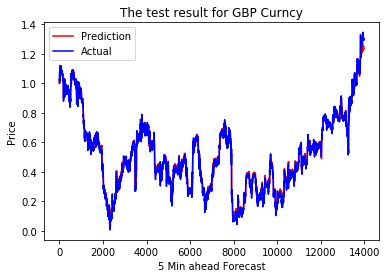

In [68]:
plot_result("GBP Curncy", p, y_test)

In [85]:
s=denormalize("GBP Curncy", y_test)

# WORKSPACE

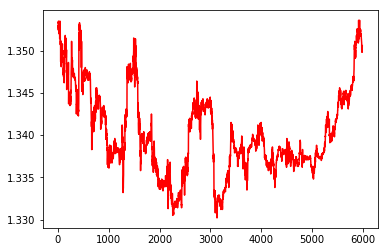

In [96]:
plt2.plot(s, color='red', label='Prediction')

In [ ]:
    stock=df_GBP
    split=0.7
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 
    result = []

    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 

    result = np.array(result)
    row = round(split * result.shape[0]) 
    print ("Amount of training data = {}".format(split * result.shape[0]))
    print ("Amount of testing data = {}".format((1-split) * result.shape[0]))

    train = result[:int(row), :] 
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

In [99]:
    stock=df_GBP
    split=0.7
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 
    result = []

Amount of features = 9


In [100]:
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 

    result = np.array(result)
    row = round(split * result.shape[0]) 
    print ("Amount of training data = {}".format(split * result.shape[0]))
    print ("Amount of testing data = {}".format((1-split) * result.shape[0]))



Amount of training data = 13981.8
Amount of testing data = 5992.200000000001


In [101]:
    train = result[:int(row), :] 
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price



In [106]:
X_train[1]

array([[0.78544061, 0.79961089, 0.78998073, 0.18487646, 0.73263144,
        0.80178064, 0.85258554, 0.87962225, 0.79885057],
       [0.79885057, 0.79766537, 0.77842004, 0.20749075, 0.6302588 ,
        0.79992581, 0.85168128, 0.8792669 , 0.77777778],
       [0.77777778, 0.78210117, 0.77842004, 0.26946511, 0.69849806,
        0.79815341, 0.85088217, 0.87889001, 0.77969349],
       [0.77969349, 0.79182879, 0.78034682, 0.19646395, 0.72694989,
        0.79691686, 0.85020924, 0.87857774, 0.79118774],
       [0.79118774, 0.78793774, 0.79190751, 0.14544163, 0.68143137,
        0.79568031, 0.84941013, 0.87825469, 0.78735632],
       [0.78735632, 0.79182879, 0.76300578, 0.23328225, 0.61885336,
        0.79419645, 0.84833764, 0.87782396, 0.76245211],
       [0.76245211, 0.75680934, 0.74566474, 0.26950249, 0.63586454,
        0.79250649, 0.84694972, 0.87728555, 0.74329502],
       [0.74329502, 0.75291829, 0.74759152, 0.17295257, 0.73269675,
        0.7911875 , 0.84564591, 0.87682252, 0.75670498],


In [107]:
y_train

array([0.74329502, 0.74329502, 0.74329502, ..., 0.96934866, 0.96743295,
       0.95785441])

In [109]:
 X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))

In [111]:
X_train[0]

array([[0.79501916, 0.79377432, 0.7822736 , 0.16065488, 0.66437187,
        0.80309962, 0.85321641, 0.87984838, 0.78544061],
       [0.78544061, 0.79961089, 0.78998073, 0.18487646, 0.73263144,
        0.80178064, 0.85258554, 0.87962225, 0.79885057],
       [0.79885057, 0.79766537, 0.77842004, 0.20749075, 0.6302588 ,
        0.79992581, 0.85168128, 0.8792669 , 0.77777778],
       [0.77777778, 0.78210117, 0.77842004, 0.26946511, 0.69849806,
        0.79815341, 0.85088217, 0.87889001, 0.77969349],
       [0.77969349, 0.79182879, 0.78034682, 0.19646395, 0.72694989,
        0.79691686, 0.85020924, 0.87857774, 0.79118774],
       [0.79118774, 0.78793774, 0.79190751, 0.14544163, 0.68143137,
        0.79568031, 0.84941013, 0.87825469, 0.78735632],
       [0.78735632, 0.79182879, 0.76300578, 0.23328225, 0.61885336,
        0.79419645, 0.84833764, 0.87782396, 0.76245211],
       [0.76245211, 0.75680934, 0.74566474, 0.26950249, 0.63586454,
        0.79250649, 0.84694972, 0.87728555, 0.74329502],


In [112]:
y_test

array([0.95402299, 0.95785441, 0.95785441, ..., 0.91187739, 0.90996169,
       0.91762452])

In [114]:
p = model.predict(X_test)

In [115]:
p

array([[0.95628846],
       [0.9523339 ],
       [0.94992006],
       ...,
       [0.9034717 ],
       [0.904866  ],
       [0.90557444]], dtype=float32)

In [116]:
len(p)

5992

In [117]:
min_max_scaler = preprocessing.MinMaxScaler()

new = min_max_scaler.inverse_transform(p)
      

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [21]:
xl.sheet_names

['Sheet1',
 'GBP Curncy',
 'JPY Curncy',
 'USD Curncy',
 'EUR Curncy',
 'CAD Curncy',
 'NZD Curncy',
 'SEK Curncy',
 'AUD Curncy',
 'CHF Curncy',
 'NOK Curncy',
 'ZAR Curncy']

In [82]:

# Load spreadsheet
close = pd.ExcelFile('close.xlsx')

In [83]:
close

In [85]:
close = pd.ExcelFile('close.xlsx')
dq=np.array(close.parse(0))

In [86]:
dq

array([[  1.3462, 111.72  ,   1.1847, ...,   0.7935,   0.9669,   7.8175],
       [  1.3465, 111.72  ,   1.1849, ...,   0.7937,   0.967 ,   7.8172],
       [  1.3466, 111.72  ,   1.1848, ...,   0.7937,   0.9669,   7.8169],
       ...,
       [  1.3522, 112.63  ,   1.1993, ...,   0.7811,   0.9746,   8.1754],
       [  1.3525, 112.62  ,   1.1993, ...,   0.7812,   0.9745,   8.1774],
       [  1.3522, 112.61  ,   1.1996, ...,   0.7811,   0.9743,   8.1868]])

In [122]:
from   mosek.fusion import *

In [130]:
n      = 3;
w      = 1.0;   
mu     = [0.1073,0.0737,0.0627]
x0     = [0.0,0.0,0.0]
gammas = [0.035,0.040,0.050,0.060,0.070,0.080,0.090]
GT     = [
        [ 0.1566673333200005, 0.0232190712557243 ,  0.0012599496030238 ],
        [ 0.0              , 0.102863378954911  , -0.00222873156550421],
        [ 0.0              , 0.0                ,  0.0338148677744977 ]]
f = n*[0.01]
g = n*[0.001]
MarkowitzWithTransactionsCost(n,mu,GT,x0,w,gammas[0],f,g)


-----------------------------------------------------------------------------------
Markowitz portfolio optimization with transactions cost
-----------------------------------------------------------------------------------

Expected return: 6.7407e-02 Std. deviation: 3.5000e-02 Transactions cost: 3.0969e-02


(0.06740718306100879, array([0.12209302, 0.10941868, 0.73751907]))